In [ ]:
%run /content/drive/MyDrive/Colab\ Notebooks/5_MLP_Dataset.ipynb

In [ ]:
import numpy as np

In [ ]:
class Office31Dataset(Dataset):
  @property
  def base(self):
    return super(Office31Dataset, self)

In [ ]:
def Office31_init(self, resolution=[100, 100], input_shape=[-1]):
  self.base.__init__('office31', 'dual_select')
  path = '/content/drive/MyDrive/ml-data/office31'
  domain_names = list_dir(path)
  images = []
  didxs, oidxs = [], []

  for dx, dname in enumerate(domain_names):
    print("Domain: "+dname)
    domainpath = os.path.join(path, dname, 'images')
    object_names = list_dir(domainpath)
    for ox, oname in enumerate(object_names):
      print("Object: "+oname)
      objectpath = os.path.join(domainpath, oname)
      filenames = list_dir(objectpath)
      for fname in filenames:
        if fname[-4:] != '.jpg':
          continue
        imagepath = os.path.join(objectpath, fname)
        pixels = load_image_pixels(imagepath, resolution, input_shape)
        images.append(pixels)
        didxs.append(dx)
        oidxs.append(ox)
  self.image_shape = resolution + [3]
  xs = np.array(images, np.float32)
  ys0 = onehot(didxs, len(domain_names))
  ys1 = onehot(oidxs, len(object_names))
  ys = np.hstack([ys0, ys1])

  self.shuffle_data(xs, ys, 0.8)
  self.target_names = [domain_names, object_names]
  self.cnts = [len(domain_names)]

In [ ]:
def office31_forward_postproc(self, output, y):
  outputs, ys = np.hsplit(output, self.cnts), np.hsplit(y, self.cnts)

  loss0, aux0 = self.base.forward_postproc(outputs[0], ys[0], 'select')
  loss1, aux1 = self.base.forward_postproc(outputs[1], ys[1], 'select')

  return loss0 + loss1, [aux0, aux1]

In [ ]:
def office31_backprop_postproc(self, G_loss, aux):
  aux0, aux1 = aux

  G_output0 = self.base.backprop_postproc(G_loss, aux0, 'select')
  G_output1 = self.base.backprop_postproc(G_loss, aux1, 'select')

  return np.hstack([G_output0, G_output1])

In [ ]:
def office31_eval_accuracy(self, x, y, output):
  outputs, ys = np.hsplit(output, self.cnts), np.hsplit(y, self.cnts)
  
  acc0 = self.base.eval_accuracy(x, ys[0], outputs[0], 'select')
  acc1 = self.base.eval_accuracy(x, ys[1], outputs[1], 'select')
  return [acc0, acc1]

def office31_train_prt_result(self, epoch, costs, accs, acc, time1, time2):
  acc_pair = np.mean(accs, axis=0)
  print('Epoch {}: cost={:5.3f},'\
        'accuracy={:5.3f}+{:5.3f}/{:5.3f}+{:5.3f} ({}/{} secs)'.\
        format(epoch, np.mean(costs), acc_pair[0], acc_pair[1], \
               acc[0], acc[1], time1, time2))

def adam_test_prt_result(self, name, acc, time):
  print('Model {} test repor: accuracy = {:5.3f}+{:5.3f}, ({} secs)\n'.\
        format(name, acc[0], acc[1], time))

In [ ]:
def office31_get_estimate(self, output):
  outputs = np.hsplit(output, self.cnts)

  estimate0 = self.base.get_estimate(outputs[0], 'select')
  estimate1 = self.base.get_estimate(outputs[1], 'select')

  return np.hstack([estimate0, estimate1])

def office31_visualize(self, xs, estimates, answers):
  draw_images_horz(xs, self.image_shape)
  ests, anss = np.hsplit(estimates, self.cnts), np.hsplit(answers, self.cnts)
  captions = ['Domain', 'Product']
  for m in range(2):
    print('[ {} result ]'.format(captions[m]))
    show_select_results(ests[m], anss[m], self.target_names[m], 8)

In [ ]:
Office31Dataset.__init__ = Office31_init
Office31Dataset.forward_postproc = office31_forward_postproc
Office31Dataset.backprop_postproc = office31_backprop_postproc
Office31Dataset.eval_accuracy = office31_eval_accuracy
Office31Dataset.get_estimate = office31_get_estimate
Office31Dataset.train_prt_result = office31_train_prt_result
Office31Dataset.test_prt_result = adam_test_prt_result
Office31Dataset.visualize = office31_visualize

In [ ]:
import pickle

od = Office31Dataset()
# with open('office31dataset.pkl', 'wb') as output:
#   pickle.dump(od, output)
# with open('office31dataset.pkl', 'rb') as input:
#   od = pickle.load(input)

Domain: amazon
Object: back_pack
Object: bike
Object: bike_helmet
Object: bookcase
Object: bottle
Object: calculator
Object: desk_chair
Object: desk_lamp
Object: desktop_computer
Object: file_cabinet
Object: headphones
Object: keyboard
Object: laptop_computer
Object: letter_tray
Object: mobile_phone
Object: monitor
Object: mouse
Object: mug
Object: paper_notebook
Object: pen
Object: phone
Object: printer
Object: projector
Object: punchers
Object: ring_binder
Object: ruler
Object: scissors
Object: speaker
Object: stapler
Object: tape_dispenser
Object: trash_can
Domain: dslr
Object: back_pack
Object: bike
Object: bike_helmet
Object: bookcase
Object: bottle
Object: calculator
Object: desk_chair
Object: desk_lamp
Object: desktop_computer
Object: file_cabinet
Object: headphones
Object: keyboard
Object: laptop_computer
Object: letter_tray
Object: mobile_phone
Object: monitor
Object: mouse
Object: mug
Object: paper_notebook
Object: pen
Object: phone
Object: printer
Object: projector
Object: p

In [ ]:
%run /content/drive/MyDrive/Colab\ Notebooks/6_AdamModel.ipynb
%run /content/drive/MyDrive/Colab\ Notebooks/mathutil.ipynb

In [ ]:
xs, ys = od.get_test_data()

In [ ]:
ys.shape

(625, 34)

Model office31_model_1 train started:
Epoch 10: cost=4.381,accuracy=0.688+0.041/0.720+0.040 (291/291 secs)
Epoch 20: cost=4.298,accuracy=0.688+0.041/0.690+0.050 (290/581 secs)
Epoch 30: cost=4.266,accuracy=0.688+0.041/0.660+0.050 (1021/1602 secs)
Epoch 40: cost=4.256,accuracy=0.688+0.041/0.660+0.050 (1063/2665 secs)
Epoch 50: cost=4.253,accuracy=0.688+0.041/0.570+0.070 (1060/3725 secs)
Model office31_model_1 train ended in 3725 secs:
Model office31_model_1 test repor: accuracy = 0.675+0.029, (1 secs)

Model office31_model_1 Visualization


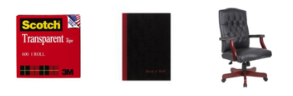

[ Domain result ]
추정확률 분포 [67,13,19] => 추정 amazon : 정답 amazon => O
추정확률 분포 [67,13,19] => 추정 amazon : 정답 amazon => O
추정확률 분포 [67,13,19] => 추정 amazon : 정답 amazon => O
[ Product result ]
추정확률 분포 [ 3, 3, 3, 3, 2, 3, 3, 3,...] => 추정 monitor : 정답 tape_dispenser => X
추정확률 분포 [ 3, 3, 3, 3, 2, 3, 3, 3,...] => 추정 monitor : 정답 paper_notebook => X
추정확률 분포 [ 3, 3, 3, 3, 2, 3, 3, 3,...] => 추정 monitor : 정답 desk_chair => X


In [ ]:
om1 = AdamModel('office31_model_1', od, [64, 32, 10])
om1.use_adam = True
om1.exec_all(epoch_count=50, report=10, learning_rate=0.0001)